# Image Classification using Scikit-Learn

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.12

## Overview

This notebook demonstrates how to build a binary image classifier using Support Vector Machine (SVM) from the `scikit-learn` library. The classifier will determine whether a given cityscape image was taken during the day or at night.

### Key Features
- **Model**: Support Vector Machine (SVM) classifier
- **Input**: RGB images
- **Output**: day/night
- **Optimization**: GridSearchCV for hyperparameter tuning

### Technical Stack
- `scikit-learn`: For SVM implementation and model evaluation
- `PIL`: For image processing
- `numpy`: For numerical operations
- `pandas`: For data manipulation
- `matplotlib`: For image visualization

### Dataset

Source: [Unpaired Day and Night cityview images](https://www.kaggle.com/datasets/heonh0/daynight-cityview)

### Import libraries

In [3]:
from PIL import Image
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

### Load dataset

In [4]:
# Define labels and directories
labels = ["day", "night"]
train_data_dir = "./train_data/"
test_data_dir = "./test_data/"

In [ ]:
def load_image_data(data_dir, labels):
    """
    Load and process image data from given directory for given labels

    Args:
        data_dir (str): Directory containing label subdirectories with images
        labels (list): List of label names/subdirectories to process

    Returns:
        tuple: (input_data, target_data) where input_data contains processed images
        and target_data contains corresponding labels
    """
    input_data = []
    target_data = []

    for label in labels:
        print(f"Loading data of class '{label}'")
        img_path = os.path.join(data_dir, label)
        for img in os.listdir(img_path):
            # Skip hidden files and non-image files
            if img.startswith('.') or not img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                continue
            with open(os.path.join(img_path, img), "rb") as f:
                image = Image.open(f).convert('RGB')
                image = image.resize((150, 150))
                # Flatten the image to a 1D array
                image = np.array(image).flatten()
                input_data.append(image)
                target_data.append(label)
        print(f"Loaded data of class '{label}' successfully")

    return np.array(input_data), np.array(target_data)

Load the image data from training and testing directories, then shuffle them randomly to prevent any potential bias from the original data ordering.

In [ ]:
# Load training and test data
train_input_data, train_target_data = load_image_data(train_data_dir, labels)
test_input_data, test_target_data = load_image_data(test_data_dir, labels)

# Shuffle the data
train_input_data, train_target_data = shuffle(train_input_data, train_target_data)
test_input_data, test_target_data = shuffle(test_input_data, test_target_data)

Convert data to pandas.DataFrame

In [ ]:
# Convert to DataFrames
train_input_data_df = pd.DataFrame(train_input_data)
train_target_data_df = pd.DataFrame(train_target_data)
test_input_data_df = pd.DataFrame(test_input_data)
test_target_data_df = pd.DataFrame(test_target_data)

### Model Architecture

We implement a Support Vector Machine (SVM) classifier using scikit-learn's `SVC` class with grid search across parameter space:
- `C`: Regularization strength (0.1 to 100)
- `gamma`: Kernel coefficient (0.0001 to 1)
- `kernel`: RBF and polynomial kernels

In [ ]:
# Defining the parameters grid for GridSearchCV
param_grid = {
    "C": [0.1, 1, 10, 100], # regularization parameter. The strength of the regularization (more general) is inversely proportional to C.
    "gamma": [0.0001, 0.001, 0.1, 1],
    "kernel": ["rbf", "poly"],
}
# Creating a support vector classifier
svc = svm.SVC(probability=True)
# Creating a model using GridSearchCV with the parameters grid
model = GridSearchCV(svc, param_grid)

Model Training

In [ ]:
# Training the model using the training data
model.fit(train_input_data_df, train_target_data_df)

Model Evaluation

In [ ]:
# Testing the model using the testing data
test_target_data_pred = model.predict(test_input_data_df)
accuracy = accuracy_score(test_target_data_pred, test_target_data_df)

# Print the accuracy of the model
print(f"Model Accuracy: {accuracy * 100}%")
print(classification_report(test_target_data_df, test_target_data_pred, target_names=labels))

### Save model for future reuse

In [ ]:
# Save model
with open("img_classifier.pkl", "wb") as f:
    pickle.dump(model, f)

### Load the saved model

In [5]:
with open('img_classifier.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

Use the loaded model to predict image class

In [8]:
def predict_image(image_path: str):
    with open(image_path,'rb') as fr:
        img=Image.open(fr)
        plt.imshow(img)
        plt.show()

        img_resized = img.resize((150,150))
        data = [np.array(img_resized).flatten()]
        probability = model.predict_proba(data)
        for idx, class_ in enumerate(labels):
            print(f'{class_} = {round(probability[0][idx] * 100, 2)}%')

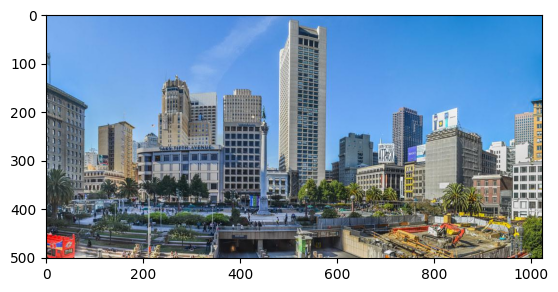

day = 100.0%
night = 0.0%


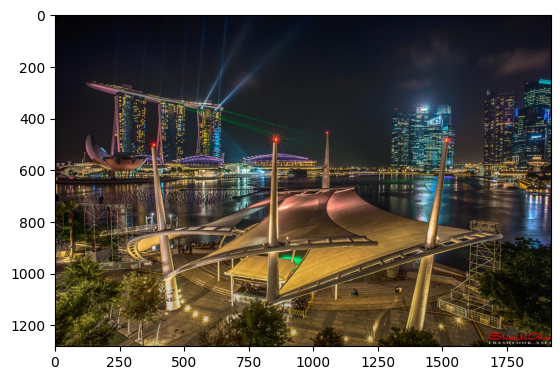

day = 2.86%
night = 97.14%


In [9]:
# Sample prediction (day)
sample_path=os.path.join(test_data_dir, 'day', '1.jpg')
predict_image(sample_path)
# Sample prediction (night)
sample_path=os.path.join(test_data_dir, 'night', '9.jpg')
predict_image(sample_path)
